In [559]:
import torch
import math
import torch.nn as nn

from datetime import datetime
from datetime import timedelta
import time

import numpy as np

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

# Functions for Informer

In [484]:
class GaussianBasisFunctions(object):
    """Function phi(t) = Gaussian(t; mu, sigma_sq)."""
    def __init__(self, mu, sigma):
        self.mu = mu.unsqueeze(0)
        self.sigma = sigma.unsqueeze(0)

    def __repr__(self):
        return f"GaussianBasisFunction(mu={self.mu}, sigma={self.sigma})"

    def __len__(self):
        """Number of basis functions."""
        return self.mu.size(1)

    def _phi(self, t):
        # N(t|0,1)
        return 1. / math.sqrt(2 * math.pi) * torch.exp(-.5 * t**2)

    def _Phi(self, t):
        return .5 * (1 + torch.erf(t / math.sqrt(2)))

    def _integrate_product_of_gaussians(self, mu, sigma_sq):
        sigma = torch.sqrt(self.sigma ** 2 + sigma_sq)
        return self._phi((mu - self.mu) / sigma) / sigma

    def evaluate(self, t):
        # N(t|mu, sigma)
        return self._phi((t - self.mu) / self.sigma) / self.sigma

    def batch_evaluate(self, t):
        t = t.repeat(self.mu.size(0),1) - self.mu.repeat(t.size(0),1).transpose(1,0)
        return self._phi(t / self.sigma) / self.sigma

    def integrate_t2_times_psi(self, a, b):
        """Compute integral int_a^b (t**2) * psi(t)."""
        return (self.mu**2 + self.sigma**2) * (
            self._Phi((b - self.mu) / self.sigma) - self._Phi((a - self.mu) / self.sigma)
        ) - (
            self.sigma * (b + self.mu) * self._phi((b - self.mu) / self.sigma)
        ) + (
            self.sigma * (a + self.mu) * self._phi((a - self.mu) / self.sigma)
        )

    def integrate_t_times_psi(self, a, b):
        """Compute integral int_a^b t * psi(t)."""
        return self.mu * (
            self._Phi((b - self.mu) / self.sigma) - self._Phi((a - self.mu) / self.sigma)
        ) - self.sigma * (
            self._phi((b - self.mu) / self.sigma) - self._phi((a - self.mu) / self.sigma)
        )

    def integrate_psi(self, a, b):
        """Compute integral int_a^b psi(t)."""
        return self._Phi((b - self.mu) / self.sigma) - self._Phi((a - self.mu) / self.sigma)

    def integrate_t2_times_psi_gaussian(self, mu, sigma_sq):
        """Compute integral int N(t; mu, sigma_sq) * t**2 * psi(t)."""
        S_tilde = self._integrate_product_of_gaussians(mu, sigma_sq)
        mu_tilde = (
            self.mu * sigma_sq + mu * self.sigma ** 2
        ) / (
            self.sigma ** 2 + sigma_sq
        )
        sigma_sq_tilde = ((self.sigma ** 2) * sigma_sq) / (self.sigma ** 2 + sigma_sq)
        return S_tilde * (mu_tilde ** 2 + sigma_sq_tilde)

    def integrate_t_times_psi_gaussian(self, mu, sigma_sq):
        """Compute integral int N(t; mu, sigma_sq) * t * psi(t)."""
        S_tilde = self._integrate_product_of_gaussians(mu, sigma_sq)
        mu_tilde = (
            self.mu * sigma_sq + mu * self.sigma ** 2
        ) / (
            self.sigma ** 2 + sigma_sq
        )
        return S_tilde * mu_tilde

    def integrate_psi_gaussian(self, mu, sigma_sq):
        """Compute integral int N(t; mu, sigma_sq) * psi(t)."""
        return self._integrate_product_of_gaussians(mu, sigma_sq)

In [485]:
torch.autograd.set_detect_anomaly(True)

class ContinuousSoftmaxFunction(torch.autograd.Function):

    @classmethod
    def _expectation_phi_psi(cls, ctx, mu, sigma_sq):
        """Compute expectation of phi(t) * psi(t).T under N(mu, sigma_sq)."""
        num_basis = [len(basis_functions) for basis_functions in ctx.psi]
        total_basis = sum(num_basis)
        V = torch.zeros((mu.shape[0], 2, total_basis), dtype=ctx.dtype,device=ctx.device)
        offsets = torch.cumsum(torch.IntTensor(num_basis).to(ctx.device), dim=0)
        start = 0
        for j, basis_functions in enumerate(ctx.psi):
            V[:, 0, start:offsets[j]] = basis_functions.integrate_t_times_psi_gaussian(mu, sigma_sq)
            V[:, 1, start:offsets[j]] = basis_functions.integrate_t2_times_psi_gaussian(mu, sigma_sq)
            start = offsets[j]
        return V

    @classmethod
    def _expectation_psi(cls, ctx, mu, sigma_sq):
        """Compute expectation of psi under N(mu, sigma_sq)."""
        num_basis = [len(basis_functions) for basis_functions in ctx.psi]
        total_basis = sum(num_basis)
        r = torch.zeros(mu.shape[0], total_basis, dtype=ctx.dtype, device=ctx.device)
        offsets = torch.cumsum(torch.IntTensor(num_basis).to(ctx.device), dim=0)
        start = 0
        for j, basis_functions in enumerate(ctx.psi):
            r[:, start:offsets[j]] = basis_functions.integrate_psi_gaussian(mu, sigma_sq)
            start = offsets[j]
        return r

    @classmethod
    def _expectation_phi(cls, ctx, mu, sigma_sq):
        """Compute expectation of phi under N(mu, sigma_sq)."""
        v = torch.zeros(mu.shape[0], 2, dtype=ctx.dtype, device=ctx.device)
        v[:, 0] = mu.squeeze(1)
        v[:, 1] = (mu**2 + sigma_sq).squeeze(1)
        return v

    @classmethod
    def forward(cls, ctx, theta, psi):
        # We assume a Gaussian.
        # We have:
        # theta = [mu/sigma**2, -1/(2*sigma**2)],
        # phi(t) = [t, t**2],
        # p(t) = Gaussian(t; mu, sigma**2).
        ctx.dtype = theta.dtype
        ctx.device = theta.device
        ctx.psi = psi
        sigma_sq = (-.5 / theta[:, 1]).unsqueeze(1)
        mu = theta[:, 0].unsqueeze(1) * sigma_sq
        r = cls._expectation_psi(ctx, mu, sigma_sq)
        ctx.save_for_backward(mu, sigma_sq, r)
        return r

    @classmethod
    def backward(cls, ctx, grad_output):
        mu, sigma_sq, r = ctx.saved_tensors
        J = cls._expectation_phi_psi(ctx, mu, sigma_sq)
        e_phi = cls._expectation_phi(ctx, mu, sigma_sq)
        e_psi = cls._expectation_psi(ctx, mu, sigma_sq)
        J -= torch.bmm(e_phi.unsqueeze(2), e_psi.unsqueeze(1))
        grad_input = torch.matmul(J, grad_output.unsqueeze(2)).squeeze(2)
        return grad_input, None


class ContinuousSoftmax(nn.Module):
    def __init__(self, psi=None):
        super(ContinuousSoftmax, self).__init__()
        self.psi = psi

    def forward(self, theta):
        return ContinuousSoftmaxFunction.apply(theta, self.psi)

# Informer

In [545]:
class LongTermAttention(nn.Module):
    # main class to compute continuous attention, with unbounded memory and sticky memories
    # like all 3rd part of article is in this class
    def __init__(self, 
                 head_size: int, 
                 length: int, 
                 attn_num_basis: int, # number of basis functions
                 attn_drop: float, 
                 n_heads: int, 
                 d_model: int, # embeding size 
                 sigma_0 = 1., 
                 mu_0 = 0., 
                 **kwargs):

        super(LongTermAttention, self).__init__()

        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

        self.length = length                   # memory length
        self.head_size = head_size
        self.attn_num_basis = attn_num_basis   # N - num of basis functions
        self.n_head = n_heads                  # number of heads
        self.nb_samples = 512                  # number of samples (from past) used for update 
        self.tau = 0.75                        # compressing factor 
        self.ridge_penalty = 1                 # ridge penalty
        self.sigma_0 = sigma_0
        self.mu_0 = mu_0

        self.B_past = None # previous coefficient matrix

        padding = True 
        
        self.proj_query = nn.Linear(n_heads * head_size, n_heads * head_size, bias=False)
        self.proj_key   = nn.Linear(n_heads * head_size, n_heads * head_size, bias=False)
        self.proj_value = nn.Linear(n_heads * head_size, n_heads * head_size, bias=False)

        self.attn_dropout = nn.Dropout(attn_drop)
        self.attn_out = nn.Linear(n_heads * head_size, d_model, bias=False)
        self.mu = nn.Linear(attn_num_basis, 1, bias=False)
        self.sigma = nn.Linear(attn_num_basis, 1, bias=False)
        self.softplus = torch.nn.Softplus()
        self.mask_net = torch.nn.Conv1d(n_heads * head_size, n_heads * head_size, 3, padding=1)
        self.transform = ContinuousSoftmax(psi=None)
        
        # get basis functions psi
        sigmas = [0.01, 0.05] # basis function sigmas 
                              # maybe also need to be changed, 
                              # this parameters was taken from original repository
        if attn_num_basis % len(sigmas):
            attn_num_basis += (len(sigmas) - attn_num_basis % len(sigmas)) 
            
        lengths  = []
        for l in range(length):
            lengths.append(l+1)
       
        self.psi = [self.get_gaussian_basis_functions(attn_num_basis, sigmas, device=self.device)]
        
        #========================== G ========================
        # computation of G = F.T @ (F @ F.T + ridge_penalty * I)^(-1)
        def compute_G(l, psi, positions):
            # G = F.T @ (F @ F.T + ridge_penalty * I)^(-1)
            F = torch.zeros(self.attn_num_basis, positions.size(0)) # [N,L]
            F[:, :] = psi.evaluate(positions.unsqueeze(1)).t() # [N,L]
            I = torch.eye(self.attn_num_basis) # [N,N]
            G = F.t().matmul((F.matmul(F.t()) + self.ridge_penalty * I).inverse()) # actual formula #[L,N]
            return G.to(self.device)
        
        # compute G 
        self.Gs  = []
        for l in lengths:
            simple_positions = []
            for i in range(l):
                simple_positions.append((i+1) / l)
            simple_positions = torch.tensor(simple_positions).to(self.device)
            self.Gs.append(compute_G(l, self.psi[0], simple_positions))
            
        # compute G for the infinite case
        self.Ginf = []
        for l in lengths:
            inf_positions = []
            tm_tau = torch.arange(1, self.nb_samples + 1).float()
            tm_l = torch.arange(self.nb_samples + 1, l + self.nb_samples + 1).float()
            tm_tau = tm_tau * self.tau / self.nb_samples # positions of old vectors
            tm_l = self.tau + (1 - self.tau) * (tm_l - self.nb_samples) / length # positions of new vectors
            positions_inf = torch.cat([tm_tau, tm_l],0).to(self.device)
            self.Ginf.append(compute_G(l, self.psi[0], positions_inf))
            
        #======================== end G ==================== 
        
        samples = None
        tm_tau = torch.arange(1, self.nb_samples + 1).float()
        tm_l = torch.arange(self.nb_samples + 1, l + self.nb_samples + 1).float()
        tm_tau = tm_tau * self.tau / self.nb_samples
        for t in tm_tau:
            if samples is None:
                samples = self.psi[0].evaluate(t/self.tau)
            else:
                samples = torch.cat([samples,self.psi[0].evaluate(t/self.tau)], dim=0)
        self.samples = samples

    def get_gaussian_basis_functions(self, nb_basis, sigmas, device):
        mu, sigma = torch.meshgrid(torch.linspace(0, 1, nb_basis // len(sigmas)), torch.Tensor(sigmas))
        mu = mu.flatten().to(device)
        sigma = sigma.flatten().to(device)
        assert mu.size(0) == nb_basis
        return GaussianBasisFunctions(mu=mu, sigma=sigma)

    def score(self, query, keys):
        query = query / (self.d_head ** 0.5) # divide by sqrt(d_head) [B,h,q,d]
        keys = keys.transpose(-1, -2)        #[B,h,d,N]
        scores = torch.matmul(query, keys)   #[B,h,q,N] 
        return scores

    def value_function(self, x, inf = False):
        #x : [B, e, L]
        if inf:
            G = self.Ginf[x.size(-1)- 1 - self.nb_samples] # [nb_sample + L, N]
        else:
            G = self.Gs[x.size(-1) - 1] # [L, N]

        B = torch.matmul(x, G)      # [B, e, N]
        B = B.permute(0,2,1)        # [B, N, e]
        return B

    def update_inf(self, x):
        l = x.shape[-1]
        if self.B_past is not None:       
            xm_tau = self.B_past.transpose(-1,-2).matmul(self.samples.transpose(0,1)) # [B,e,nb_samples]
            x = torch.cat([xm_tau,x], dim=2)       # [B, e, nb_samples + L]
            B = self.value_function(x, inf = True) # [B, N, e]
        else:
            B = self.value_function(x) # [B, N, e]
        self.B_past = B.detach()
        return B

    def forward(self, k, q, new_doc = False, reg_mask = None):  
        # k, q: [L, batch size, emb]
        batch_size = k.size(1)       #batch size
        qlen = q.size(0)             #query length
        klen = k.size(0)             #key length
        self.d_head = self.head_size #head size

        # clean memory if going through different document
        if new_doc:
            self.B_past = None 
            
        k = k.permute(1,2,0) # [B,e,L]
        reg_mask = torch.sigmoid(self.mask_net(k))  
        k = k * reg_mask

        # perform memory update
        B = self.update_inf(k)
        
        query  = q.permute(1,0,2)
        keys   = self.proj_key(B)
        values = self.proj_value(B)

        query  = query.view(batch_size, qlen, self.n_head, self.d_head).transpose(1,2)                 # [B,h,q,d]
        keys   = keys.view(batch_size, self.attn_num_basis, self.n_head, self.d_head).transpose(1,2)   # [B,h,N,d]
        values = values.view(batch_size, self.attn_num_basis, self.n_head, self.d_head).transpose(1,2) # [B,h,N,d]
        
        #compute scores
        scores = self.score(query, keys) #[B,h,q,N] 

        #computing mu and sigma
        mu = torch.sigmoid(self.mu(scores)) #[B,h,q] 
        sigma_sq = self.softplus(self.sigma(scores))#[B,h,q] 
        mu = mu.view(-1)
        sigma_sq = torch.clamp(sigma_sq, min=1e-6).view(-1)

        sigma_0_sq = self.sigma_0**2
        # computing kl_loss
        if self.mu_0 is None:
            kl_reg = 1/2 * (sigma_sq.view(batch_size, -1) / sigma_0_sq - 
                        torch.log(sigma_sq.view(batch_size, -1) / sigma_0_sq) - 1)
        else:
            kl_reg = 1/2 * (sigma_sq.view(batch_size, -1) / sigma_0_sq - 
                            torch.log(sigma_sq.view(batch_size,-1) / sigma_0_sq) - 1 +
                            (mu.view(batch_size,-1) - self.mu_0) ** 2 / sigma_0_sq )
        theta = torch.zeros(batch_size * self.n_head * qlen, 2, device = self.device)  # [B*h*q, 2]
        theta[:, 0] = mu / sigma_sq
        theta[:, 1] = -1. / (2. * sigma_sq)

        # get basis functions
        self.transform.psi = self.psi

        #compute basis functions expectation
        r = self.transform(theta) # [B*h*q,N] 
        r = r.view(batch_size, self.n_head, qlen, self.attn_num_basis).permute(0,1,3,2) # [B,h,N,q]

        values = values.transpose(-1,-2)   # [B,h,d,N]
        context = torch.matmul(values,r)   # [B,h,d,q]
        context = context.permute(3,0,1,2) # [q,B,h,d]
        context = context.contiguous().view(qlen, batch_size, self.n_head * self.d_head) # [q,B,e]
        context = self.attn_out(context) # the Long Term Memory (LTM) representation     # [q,B,d_model]
        
        return context, kl_reg
        

In [546]:
hidden_size=45
num_heads=4
num_layers=1
head_size = 15
L = 1000
bs = 512
dim_feedforward = 4 * hidden_size
lt_att = LongTermAttention(head_size = head_size,
                 length =  L,
                 attn_num_basis = 100, 
                 attn_drop = 0.1, 
                 n_heads = num_heads, 
                 d_model = hidden_size,
                 sigma_0 = 0,
                 mu_0 = 0)

In [547]:
q = torch.rand(L, bs, head_size*num_heads)
k = torch.rand(L, bs, head_size*num_heads)

start_time = datetime.now()
z, kl_loss = lt_att(q,k)
print(datetime.now() - start_time)
z.shape, kl_loss.shape


0:00:45.095000


(torch.Size([1000, 512, 45]), torch.Size([512, 4000]))

# Baseline

In [490]:
"""REPO_NAME = "MSDProject"
!if [ -d {REPO_NAME} ]; then rm -Rf {REPO_NAME}; fi
!git clone https://github.com/NonameUntitled/{REPO_NAME}.git
!cd {REPO_NAME}"""

'REPO_NAME = "MSDProject"\n!if [ -d {REPO_NAME} ]; then rm -Rf {REPO_NAME}; fi\n!git clone https://github.com/NonameUntitled/{REPO_NAME}.git\n!cd {REPO_NAME}'

In [491]:
import inspect

class MetaParent(type):

    def __init__(cls, name, base, params, **kwargs):
        super().__init__(name, base, params)
        is_base_class = cls.mro()[1] is object
        if is_base_class:
            base_class = cls
        else:
            base_class_found = False
            for key in cls.mro():
                if isinstance(key, MetaParent) and key.mro()[1] is object:
                    assert base_class_found is False, 'multiple base classes(bug)'
                    base_class = key
                    base_class_found = True
            assert base_class_found is True, f'no base class for {name}'

        if is_base_class:
            cls._subclasses = {}

        @classmethod
        def __init_subclass__(scls, config_name=None):
            super().__init_subclass__()
            if config_name is not None:
                if config_name in base_class._subclasses:
                    raise ValueError("Class with name `{}` is already registered".format(config_name))
                base_class._subclasses[config_name] = scls

        cls.__init_subclass__ = __init_subclass__

        @classmethod
        def parent_create_from_config(cls, config, **kwargs):
            if 'type' in config:
                return cls._subclasses[config['type']].create_from_config(config, **kwargs)
            else:
                raise ValueError('There is no `type` provided for the `{}` class'.format(name))

        # Take kwargs for the last initialized baseclass
        init_kwargs = {}
        for bcls in cls.mro()[:-1]:  # Look into all base classes except object
            if '__init__' not in bcls.__dict__:
                continue
            init_kwargs = inspect.signature(bcls.__init__).parameters
            break

        @classmethod
        def child_create_from_config(cls, config, **kwargs):
            kwargs = {}
            for key, argspec in init_kwargs.items():
                if key == 'self':
                    continue
                value = config.get(key, argspec.default)
                if value is inspect.Parameter.empty:
                    msg = 'There is no value for `{}.__init__` required field `{}` in config `{}`'
                    raise ValueError(msg.format(cls, key, config))
                kwargs[key] = value
            return cls(**kwargs)

        if 'create_from_config' not in cls.__dict__:
            cls.create_from_config = parent_create_from_config if is_base_class else child_create_from_config


class BaseModel(metaclass=MetaParent):
    pass


class TorchModel(nn.Module, BaseModel):
    pass

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

class BaselineProjector(torch.nn.Module):

    def __init__(
            self,
            embedding_dim,
            num_types,
            num_codes,
            max_sequence_len,
            use_positions=True,
            use_log_amount=True,
            use_layernorm=True,
            eps=1e-5,
            dropout=0.0,
            aggregation_type='sum',
            initializer_range=0.02
    ):
        super().__init__()

        self._embedding_dim = embedding_dim

        self._num_types = num_types
        self._num_codes = num_codes
        self._max_sequence_len = max_sequence_len

        self._use_positions = use_positions
        self._use_log_amount = use_log_amount
        self._use_layernorm = use_layernorm
        self._eps = eps
        self._dropout = dropout
        self._aggregation_type = aggregation_type

        self._types_embedding = nn.Embedding(
            num_embeddings=self._num_types + 2,
            embedding_dim=self._embedding_dim
        )

        self._codes_embedding = nn.Embedding(
            num_embeddings=self._num_codes + 2,
            embedding_dim=self._embedding_dim
        )

        self._amount_layer = nn.Linear(
            in_features=1, out_features=self._embedding_dim
        )

        self._position_embedding = nn.Identity()
        if self._use_positions:
            self._position_embedding = nn.Embedding(
                num_embeddings=self._max_sequence_len + 1,
                embedding_dim=self._embedding_dim
            )

        self._dropout = nn.Dropout(p=self._dropout)
        self._layernorm = nn.LayerNorm(self._embedding_dim, eps=self._eps)

        self._init_weights(initializer_range)

        self._output_dim = self._embedding_dim if self._aggregation_type == 'sum' \
            else (3 + self._use_positions) * self._embedding_dim

    @classmethod
    def create_from_config(cls, config, **kwargs):
        return cls(
            embedding_dim=config['embedding_dim'],
            num_types=kwargs['num_types'],
            num_codes=kwargs['num_codes'],
            max_sequence_len=kwargs['max_sequence_len'],
            use_positions=config.get('use_positions', True),
            use_log_amount=config.get('use_log_amount', True),
            use_layernorm=config.get('use_layernorm', True),
            eps=config.get('eps', 1e-5),
            dropout=config.get('dropout', 0.0),
            aggregation_type=config.get('aggregation_type', 'sum'),
            initializer_range=config.get('initializer_range', 0.02)
        )

    @torch.no_grad()
    def _init_weights(self, initializer_range):
        nn.init.trunc_normal_(
            self._types_embedding.weight.data,
            std=initializer_range,
            a=-2 * initializer_range,
            b=2 * initializer_range
        )

        nn.init.uniform_(self._amount_layer.weight.data, a=initializer_range, b=initializer_range)
        nn.init.uniform_(self._amount_layer.bias.data, a=initializer_range, b=initializer_range)

        nn.init.trunc_normal_(
            self._codes_embedding.weight.data,
            std=initializer_range,
            a=-2 * initializer_range,
            b=2 * initializer_range
        )

        if self._use_positions:
            nn.init.trunc_normal_(
                self._position_embedding.weight.data,
                std=initializer_range,
                a=-2 * initializer_range,
                b=2 * initializer_range
            )

        nn.init.ones_(self._layernorm.weight.data)
        nn.init.zeros_(self._layernorm.bias.data)

    @property
    def output_dim(self):
        return self._output_dim

    def forward(self, inputs):
        mcc_code = inputs['mcc_code']  # (all_batch_events)
        transaction_type = inputs['transaction_type']  # (all_batch_events)
        amount = inputs['amount']  # (all_batch_events)

        mcc_code_embeddings = self._dropout(self._codes_embedding(mcc_code))  # (all_batch_events, embedding_dim)
        transaction_type_embeddings = self._dropout(self._types_embedding(transaction_type))  # (all_batch_events, embedding_dim)

        if self._use_log_amount:
            amount = torch.sign(amount) * torch.log(1. + torch.abs(amount))
        amount_embeddings = self._dropout(self._amount_layer(amount.unsqueeze(-1)))

        embeddings = [mcc_code_embeddings, transaction_type_embeddings, amount_embeddings]  # (3, all_batch_events, embedding_dim)

        if self._use_positions:
            position = inputs['positions']  # (all_batch_events)
            position_embeddings = self._position_embedding(position)  # (all_batch_events, embedding_dim)
            embeddings.append(position_embeddings)

        if self._aggregation_type == 'sum':
            embedding = None
            for e in embeddings:
                if embedding is None:
                    embedding = e
                else:
                    embedding += e
        else:
            assert self._aggregation_type == 'concat'
            embedding = torch.cat(embeddings, dim=0)

        lengths = inputs['lengths']  # (batch_size)
        batch_size = lengths.shape[0]
        max_sequence_length = lengths.max().item()

        padded_embeddings = torch.zeros(
            batch_size, max_sequence_length,
            self._embedding_dim if self._aggregation_type == 'sum' else self._embedding_dim * len(embeddings),
            dtype=torch.float, device=DEVICE
        )  # (batch_size, max_seq_len, emb_dim)

        mask = torch.arange(
            end=max_sequence_length,
            device=DEVICE
        )[None].tile([batch_size, 1]) < lengths[:, None]  # (batch_size, max_seq_len)

        padded_embeddings[mask] = embedding
        if self._use_layernorm:
            padded_embeddings = self._layernorm(padded_embeddings)

        return padded_embeddings, mask


class BaselineEncoder(torch.nn.Module):

    def __init__(
            self,
            hidden_size,
            num_heads,
            num_layers,
            dim_feedforward,
            dropout=0.0,
            activation='relu',
            layer_norm_eps=1e-5,
            input_dim=None,
            output_dim=None,
            user_cls_only=False,
            initializer_range=0.02
    ):
        super().__init__()

        self._input_projection = nn.Identity()
        if input_dim is not None:
            self._input_projection = nn.Linear(input_dim, hidden_size)

        transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation=get_activation_function(activation),
            layer_norm_eps=layer_norm_eps,
            batch_first=True
        )
        self._encoder = nn.TransformerEncoder(transformer_encoder_layer, num_layers)

        self._output_projection = nn.Identity()
        if output_dim is not None:
            self._output_projection = nn.Linear(hidden_size, output_dim)

        self._user_cls_only = user_cls_only

        self._init_weights(initializer_range)

    @classmethod
    def create_from_config(cls, config, **kwargs):
        return cls(
            hidden_size=config['hidden_size'],
            num_heads=config['num_heads'],
            num_layers=config['num_layers'],
            dim_feedforward=config.get('dim_feedforward', 4 * config['hidden_size']),
            dropout=config.get('dropout', 0.0),
            activation=config.get('activation', 'relu'),
            layer_norm_eps=config.get('layer_norm_eps', 1e-5),
            input_dim=kwargs['input_dim'],
            output_dim=config.get('output_dim', None),
            user_cls_only=config.get('user_cls_only', False),
            initializer_range=config.get('initializer_range', 0.02)
        )

    @torch.no_grad()
    def _init_weights(self, initializer_range):
        for key, value in self.named_parameters():
            if 'weight' in key:
                if 'norm' in key:
                    nn.init.ones_(value.data)
                else:
                    nn.init.trunc_normal_(
                        value.data,
                        std=initializer_range,
                        a=-2 * initializer_range,
                        b=2 * initializer_range
                    )
            elif 'bias' in key:
                nn.init.zeros_(value.data)
            else:
                raise ValueError(f'Unknown transformer weight: {key}')

    def forward(self, embeddings, attention_mask):
        embeddings = self._input_projection(embeddings)  # (batch_size, seq_len, emb_dim)
        embeddings = self._encoder(
            src=embeddings,
            src_key_padding_mask=~attention_mask
        )  # (batch_size, seq_len, emb_dim)
        embeddings = self._output_projection(embeddings)  # (batch_size, seq_len, output_emb_dim)
        if self._user_cls_only:
            embeddings = embeddings[:, 0, :]  # (batch_size, output_emb_dim)
            attention_mask = attention_mask[:, 0]  # (batch_size)
        return embeddings, attention_mask


class BaselineModel(TorchModel, config_name='baseline'):

    def __init__(self, projector, encoder):
        super().__init__()
        self._projector = projector
        self._encoder = encoder

    @classmethod
    def create_from_config(cls, config, **kwargs):
        projector = BaselineProjector.create_from_config(config['projector'], **kwargs)
        encoder = BaselineEncoder.create_from_config(
            config['encoder'],
            input_dim=projector.output_dim,
            **kwargs
        )
        return cls(projector, encoder)

    def forward(self, inputs):
        embeddings, mask = self._projector(inputs)
        embeddings, mask = self._encoder(embeddings, mask)
        return embeddings


In [492]:
def get_activation_function(name, **kwargs):
    if name == 'relu':
        return torch.nn.ReLU()
    elif name == 'gelu':
        return torch.nn.GELU()
    elif name == 'elu':
        return torch.nn.ELU(alpha=float(kwargs.get('alpha', 1.0)))
    elif name == 'leaky':
        return torch.nn.LeakyReLU(negative_slope=float(kwargs.get('negative_slope', 1e-2)))
    elif name == 'sigmoid':
        return torch.nn.Sigmoid()
    elif name == 'tanh':
        return torch.nn.Tanh()
    elif name == 'softmax':
        return torch.nn.Softmax()
    elif name == 'softplus':
        return torch.nn.Softplus(beta=int(kwargs.get('beta', 1.0)), threshold=int(kwargs.get('threshold', 20)))
    elif name == 'softmax_logit':
        return torch.nn.LogSoftmax()
    else:
        raise ValueError('Unknown activation function name `{}`'.format(name))


# Test of speed

In [552]:
hidden_size = 45
num_heads = 4
num_layers = 1
head_size = 15
L = 500
bs = 512

dim_feedforward = head_size * num_heads

base = BaselineEncoder(hidden_size = head_size * num_heads, # hidden size need to be devidable by num_heads # embedings
                num_heads = num_heads,
                num_layers = num_layers,
                dim_feedforward = head_size * num_heads)

lt_att = LongTermAttention(head_size = head_size,
                 length =  L,
                 target_len =  1,
                 attn_num_basis = 100, 
                 attn_drop = 0.1, 
                 n_heads = num_heads, 
                 d_model = 1 ,#for classification
                 sigma_0 = 1.0,
                 mu_0 = 0.0)

In [553]:
emb_dim = head_size * num_heads

x = torch.rand(bs, L, head_size * num_heads) 
att = torch.rand(bs, L) > 0.5
print("x.shape", x.shape)
print("mask.shape", att.shape)

start_time = datetime.now()

z, l = base(x, att)

print(datetime.now() - start_time)

z.shape, l.shape

# Baseline [bs, L, hidden_size], [bs, L] -> [bs, L, hidden_size], [bs, L] #hidden_size = head_size * num_heads

x.shape torch.Size([512, 500, 60])
mask.shape torch.Size([512, 500])
0:00:14.278000


(torch.Size([512, 500, 60]), torch.Size([512, 500]))

In [554]:
x = torch.rand(L, bs, head_size * num_heads)
print("x.shape", x.shape)
start_time = datetime.now()
z, kl_loss = lt_att(x,x)
print(datetime.now() - start_time)
z.shape, kl_loss.shape

# LongTermAttention [L, bs, head_size * num_head] x 2 -> [L, bs, d_model], [bs, L * num_heads]

x.shape torch.Size([500, 512, 60])
0:00:09.946000


(torch.Size([500, 512, 1]), torch.Size([512, 2000]))

# Full Baseline

In [496]:
class BaselineModel(nn.Module):

    def __init__(self, projector, encoder):
        super().__init__()
        self._projector = projector
        self._encoder = encoder

    """@classmethod
    def create_from_config(cls, config, **kwargs):
        projector = BaselineProjector.create_from_config(config['projector'], **kwargs)
        encoder = BaselineEncoder.create_from_config(
            config['encoder'],
            input_dim=projector.output_dim,
            **kwargs
        )
        return cls(projector, encoder)"""

    def forward(self, inputs):
        embeddings, mask = self._projector(inputs)
        embeddings, mask = self._encoder(embeddings, mask)
        return {"predictions": embeddings}

# Model

In [577]:
class SimpleInformerModel(nn.Module):

    def __init__(self, 
                 num_types,
                 num_codes, 
                 max_sequence_len,
                 num_heads, 
                 embedding_dim,
                 n_heads, 
                 target_len = 70, 
                 attn_num_basis = 100,
                 attn_drop = 0., 
                 sigma_0 = 1., 
                 mu_0 = 0.
                 ):
        super().__init__()
        self._projector = BaselineProjector(embedding_dim = 32, 
                                            num_types = num_types, 
                                            num_codes = num_codes,
                                            max_sequence_len = max_sequence_len)
        assert embedding_dim % n_heads == 0
        self._encoder = LongTermAttention(head_size = int(embedding_dim / n_heads),
                                          length = max_sequence_len, 
                                          target_len = target_len, 
                                          attn_num_basis = attn_num_basis,
                                          attn_drop = attn_drop, 
                                          n_heads = n_heads,
                                          d_model = 1, 
                                          sigma_0 = sigma_0, 
                                          mu_0 = mu_0)
        
    def forward(self, inputs):
        embeddings, mask = self._projector(inputs) # [bs, L, emb_dim]
        embeddings = embeddings.permute(1,0,2) # [L, bs, emb_dim] 
        embeddings, kl_loss  = self._encoder(embeddings, embeddings) # [L, bs, d_model], [bs, L * num_heads] 
        embeddings = embeddings.permute(1,0,2) # [bs, L, d_model]
        embeddings = embeddings[:, 0, :]
        kl_loss = kl_loss.mean()

        return {"predictions": embeddings, "kl_loss": kl_loss}


# Data

In [498]:

import os
import logging
import pickle
import pandas as pd
import torch.utils.data

from tqdm import tqdm
from collections import defaultdict

TRANSACTION_DATASET_NAME = 'transactions.bin'


class BaseDataset:

    def __init__(
            self,
            path_to_transactions,
            path_to_train_labels,
            path_to_test_labels,
            val_size=0.2,
            min_history_len=None,
            max_history_len=None
    ):
        self._path_to_transactions = path_to_transactions
        self._path_to_train_labels = path_to_train_labels
        self._path_to_test_labels = path_to_test_labels
        self._val_size = val_size

        self._min_history_len = min_history_len
        self._max_history_len = max_history_len

        # Dataset meta-information part
        self._num_types = 0
        self._num_codes = 0
        self._max_sequence_len = 0
        customer_id_mapping = {}

        # Process all transactions
        customers_history = defaultdict(list)

        if not os.path.exists(TRANSACTION_DATASET_NAME):
            transactions_dataset = pd.read_csv(self._path_to_transactions)
            for _, row in tqdm(transactions_dataset.iterrows(), desc='Creating transactions dataset...'):
                customer_id = int(row['customer_id'])
                customer_id_fact = int(row['customer_id_factorized'])

                customer_id_mapping[customer_id] = customer_id_fact

                mcc_code = int(row['mcc_code_factorized'])
                transaction_type = int(row['tr_type_factorized'])
                amount = float(row['amount_log'])
                timestamp = int(row['timestamp'])

                customers_history[customer_id_fact].append({
                    'mcc_code.idx': mcc_code,
                    'transaction_type.idx': transaction_type,
                    'amount.value': amount,
                    'timestamp': timestamp
                })

                self._num_codes = max(self._num_codes, mcc_code)
                self._num_types = max(self._num_types, transaction_type)

            # Sort by timestamp
            for customer_id, transactions in tqdm(customers_history.items(), desc='Sort all histories by timestamp...'):
                customers_history[customer_id] = sorted(transactions, key=lambda x: x['timestamp'])
                if self._max_history_len:
                    customers_history[customer_id] = customers_history[customer_id][-self._max_history_len:]
                self._max_sequence_len = max(self._max_sequence_len, len(customers_history[customer_id]))

            status = (self._num_types, self._num_codes, self._max_sequence_len, customer_id_mapping, customers_history)

            with open(TRANSACTION_DATASET_NAME, 'wb') as f:
                pickle.dump(status, f)
        else:
            with open(TRANSACTION_DATASET_NAME, 'rb') as f:
                status = pickle.load(f)

            self._num_types, self._num_codes, self._max_sequence_len, customer_id_mapping, customers_history = status

        self._customers_history = customers_history

        # Train labels part
        train_data = []
        train_labels = pd.read_csv(self._path_to_train_labels)
        for _, row in tqdm(train_labels.iterrows(), desc='Assigning train labels...'):
            customer_id = int(row['customer_id'])
            customer_id_fact = customer_id_mapping[customer_id]
            label = int(row['gender'])

            train_data.append({
                'sample': customers_history[customer_id_fact],
                'label': label
            })

        self._train_dataset = train_data

        self._val_dataset = self._train_dataset[int(len(self._train_dataset) * (1 - self._val_size)):]
        self._train_dataset = self._train_dataset[:int(len(self._train_dataset) * (1 - self._val_size))]

        # Test labels part
        test_data = []
        test_labels = pd.read_csv(self._path_to_test_labels)
        for _, row in tqdm(test_labels.iterrows(), desc='Assigning test labels...'):
            customer_id = int(row['customer_id'])
            customer_id_fact = customer_id_mapping[customer_id]
            train_data.append({'sample': customers_history[customer_id_fact]})

        self._test_dataset = test_data

    @property
    def num_types(self):
        return self._num_types

    @property
    def num_codes(self):
        return self._num_codes

    @property
    def max_sequence_len(self):
        return self._max_sequence_len

    @property
    def datasets(self):
        return self._train_dataset, self._val_dataset, self._test_dataset


class BatchProcessor:

    def __call__(self, batch):
        processed_batch = {}

        processed_batch['lengths'] = []
        for sample in batch:
            processed_batch['lengths'].append(len(sample['sample']))
        processed_batch['lengths'] = torch.tensor(processed_batch['lengths'], dtype=torch.long)

        processed_batch['labels'] = []
        for sample in batch:
            processed_batch['labels'].append(sample['label'])
        processed_batch['labels'] = torch.tensor(processed_batch['labels'], dtype=torch.long)

        processed_batch['positions'] = []
        for sample in batch:
            processed_batch['positions'].extend(list(range(len(sample['sample']))))
        processed_batch['positions'] = torch.tensor(processed_batch['positions'], dtype=torch.long)

        for key in batch[0]['sample'][0].keys():
            if key.endswith('.idx'):  # categorical feature
                prefix = key.split('.')[0]
                processed_batch[prefix] = []
                for sample in batch:
                    for event in sample['sample']:
                        processed_batch[prefix].append(event[key])

                processed_batch[prefix] = torch.tensor(processed_batch[prefix], dtype=torch.long)
            elif key.endswith('.value'):  # scalar feature
                prefix = key.split('.')[0]
                processed_batch[prefix] = []
                for sample in batch:
                    for event in sample['sample']:
                        processed_batch[prefix].append(event[key])

                processed_batch[prefix] = torch.tensor(processed_batch[prefix], dtype=torch.float)
            # else:
            #     print(f'Unused feature: {key}')

        return processed_batch

In [499]:
import os
path_to_transactions = os.path.join("", 'transactions.csv')
path_to_train_labels = os.path.join("", 'gender_train.csv')
path_to_test_labels = os.path.join("", 'gender_test_kaggle_sample_submission.csv')

dataset = BaseDataset(
        path_to_transactions=path_to_transactions,
        path_to_train_labels=path_to_train_labels,
        path_to_test_labels=path_to_test_labels,
        val_size=0.2,
        max_history_len=2000  # !!!Important!!!
    )

print(f'Dataset meta-information: num_types={dataset.num_types}, '
          f'num_codes={dataset.num_codes}, '
          f'max_sequence_len={dataset.max_sequence_len}')

train_dataset, val_dataset, _ = dataset.datasets

train_dataloader = DataLoader(train_dataset, batch_size = 8, shuffle= True, drop_last = True, collate_fn=BatchProcessor())

val_dataloader = DataLoader(val_dataset, batch_size = 8, shuffle= True, drop_last = True, collate_fn=BatchProcessor())


Assigning train labels...: 8400it [00:02, 3329.37it/s]
Assigning test labels...: 3600it [00:00, 4761.90it/s]


Dataset meta-information: num_types=76, num_codes=183, max_sequence_len=4000


# Train

In [584]:

def train(dataloader, model, optimizer, loss_function, epoch_cnt, alpha = 0.0):
    step_num = 0
    losses_per_steps = []
    losses_per_epoches = []

    print('Start training...')

    for epoch in range(epoch_cnt):
        tmp_losses = []
        print(f'Start epoch {epoch}')
        for step, inputs in enumerate(dataloader):
            model.train()

            for key, values in inputs.items():
                inputs[key] = inputs[key].to(DEVICE)

            predicts = model(inputs)
            labels = inputs['labels'].float()
            loss = loss_function(predicts["predictions"].squeeze(), labels)
            print("loss", loss)
            if "kl_loss" in predicts.keys():
                loss += alpha * predicts["kl_loss"]
                print("kl_loss", predicts["kl_loss"])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #print('predicts', predicts, 'labels', labels, 'loss', loss)
            print('loss', loss)
            losses_per_steps.append(loss.detach().cpu().numpy())
            tmp_losses.append(loss.detach().cpu().numpy())
            step_num += 1
            #print(losses_per_steps)
            #print(np.mean(losses_per_steps))
        losses_per_epoches.append(np.mean(tmp_losses))

    print('Training procedure has been finished!')
    return losses_per_epoches, losses_per_steps

In [598]:
#some tests

proj = BaselineProjector(32, num_types = 76, num_codes = 183, max_sequence_len = 4000)
encoder = BaselineEncoder(input_dim = 32, output_dim = 1, hidden_size = 32, 
                          num_heads = 2, num_layers = 1, dim_feedforward = 6, 
                          user_cls_only = True)

model = BaselineModel(proj, encoder)
for dat in train_dataloader:
    print("lengths", dat["lengths"].shape)
    print("labels", dat["labels"].shape)
    print("positions", dat["positions"].shape)
    print("mcc_code", dat["mcc_code"].shape)
    print("transaction_type", dat["transaction_type"].shape)
    print("amount", dat["amount"].shape)
    print(proj(dat)[0].shape, proj(dat)[1].shape)
    print(encoder(proj(dat)[0], proj(dat)[1])[0].shape)
    print(encoder(proj(dat)[0], proj(dat)[1])[1].shape)
    print(model(dat)["predictions"].squeeze().shape)
    
    break

lengths torch.Size([8])
labels torch.Size([8])
positions torch.Size([3776])
mcc_code torch.Size([3776])
transaction_type torch.Size([3776])
amount torch.Size([3776])
torch.Size([8, 1490, 32]) torch.Size([8, 1490])
torch.Size([8, 1])
torch.Size([8])
torch.Size([8])


In [599]:
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_function = torch.nn.BCEWithLogitsLoss()

In [600]:
# Train process
losses_per_epoches, losses_per_steps = train(dataloader=val_dataloader, 
                                             model=model, optimizer=optimizer, 
                                             loss_function=loss_function, epoch_cnt= 3)

Start training...
Start epoch 0
loss tensor(0.6763, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6763, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6922, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6922, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6835, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6835, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6863, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6863, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6802, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6802, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6924, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6924, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6857, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6857, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
lo

loss tensor(0.6981, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6845, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6845, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7172, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7172, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6470, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6470, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6657, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6657, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7153, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7153, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6714, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6714, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7340, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7340, grad_fn=<Binar

loss tensor(0.7347, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7347, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7438, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7438, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6805, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6805, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6103, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6103, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6446, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6446, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7303, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7303, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6071, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6071, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.5856, grad_fn=<Binar

loss tensor(0.6607, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6570, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6570, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6907, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6907, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7470, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7470, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6664, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6664, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6860, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6860, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6827, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6827, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6396, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6396, grad_fn=<Binar

loss tensor(0.6768, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6768, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7016, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7016, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7184, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7184, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6372, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6372, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6647, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6647, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.5941, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.5941, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6215, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6215, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6311, grad_fn=<Binar

loss tensor(0.5923, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.8712, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.8712, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7089, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7089, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6523, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6523, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7206, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7206, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6675, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6675, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6454, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6454, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7474, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7474, grad_fn=<Binar

loss tensor(0.7624, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7624, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.5979, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.5979, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7330, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7330, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7353, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7353, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6815, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6815, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7116, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7116, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6758, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6758, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6945, grad_fn=<Binar

loss tensor(0.6629, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6738, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6738, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6853, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6853, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6486, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6486, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Start epoch 2
loss tensor(0.7222, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7222, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6388, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6388, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7037, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7037, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6607, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6607, 

loss tensor(0.6146, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6146, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6978, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6978, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7089, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7089, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6190, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6190, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.5968, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.5968, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6641, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6641, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6473, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6473, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6549, grad_fn=<Binar

loss tensor(0.6336, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7002, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7002, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7292, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7292, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6536, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6536, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6883, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6883, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6546, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6546, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7022, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7022, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6119, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6119, grad_fn=<Binar

loss tensor(0.7319, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7319, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6154, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6154, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6807, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6807, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6842, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6842, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6339, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6339, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.5913, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.5913, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6105, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6105, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6969, grad_fn=<Binar

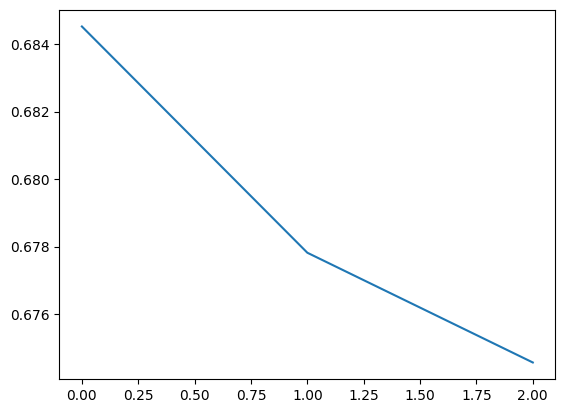

In [602]:
# wow it takes much time
plt.plot(losses_per_epoches)

In [603]:
model_inf = SimpleInformerModel(num_types = 76, 
                                num_codes = 183, 
                                max_sequence_len = 4000,
                                num_heads = 2, 
                                embedding_dim = 32, 
                                n_heads = 2, 
                                target_len = 1, 
                                attn_num_basis = 2)

In [604]:
model_inf

SimpleInformerModel(
  (_projector): BaselineProjector(
    (_types_embedding): Embedding(78, 32)
    (_codes_embedding): Embedding(185, 32)
    (_amount_layer): Linear(in_features=1, out_features=32, bias=True)
    (_position_embedding): Embedding(4001, 32)
    (_dropout): Dropout(p=0.0, inplace=False)
    (_layernorm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  )
  (_encoder): LongTermAttention(
    (proj_query): Linear(in_features=32, out_features=32, bias=False)
    (proj_key): Linear(in_features=32, out_features=32, bias=False)
    (proj_value): Linear(in_features=32, out_features=32, bias=False)
    (attn_dropout): Dropout(p=0.0, inplace=False)
    (attn_out): Linear(in_features=32, out_features=1, bias=False)
    (mu): Linear(in_features=2, out_features=1, bias=False)
    (sigma): Linear(in_features=2, out_features=1, bias=False)
    (softplus): Softplus(beta=1, threshold=20)
    (mask_net): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (transform):

In [605]:
for i, dat in enumerate(train_dataloader):
    print("input length of seq", dat["lengths"].max())
    res = model_inf(dat)
    print("prediction", res["predictions"].shape)
    print("kl_loss", res["kl_loss"].shape)
    if i > 10:
        break

input length of seq tensor(1076)
prediction torch.Size([8, 1])
kl_loss torch.Size([])
input length of seq tensor(1471)
prediction torch.Size([8, 1])
kl_loss torch.Size([])
input length of seq tensor(1784)
prediction torch.Size([8, 1])
kl_loss torch.Size([])
input length of seq tensor(999)
prediction torch.Size([8, 1])
kl_loss torch.Size([])
input length of seq tensor(834)
prediction torch.Size([8, 1])
kl_loss torch.Size([])
input length of seq tensor(1814)
prediction torch.Size([8, 1])
kl_loss torch.Size([])
input length of seq tensor(792)
prediction torch.Size([8, 1])
kl_loss torch.Size([])
input length of seq tensor(1017)
prediction torch.Size([8, 1])
kl_loss torch.Size([])
input length of seq tensor(1308)
prediction torch.Size([8, 1])
kl_loss torch.Size([])
input length of seq tensor(700)
prediction torch.Size([8, 1])
kl_loss torch.Size([])
input length of seq tensor(692)
prediction torch.Size([8, 1])
kl_loss torch.Size([])
input length of seq tensor(760)
prediction torch.Size([8, 1

In [606]:
# Train process
losses_per_epoches_inf, losses_per_steps_inf = train(dataloader=val_dataloader, 
                                             model=model_inf, optimizer=optimizer, 
                                             loss_function=loss_function, epoch_cnt= 3,
                                            alpha = 0.1)

Start training...
Start epoch 0
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6932, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6932, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7087, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6932, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
lo

loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<Binar

loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<Binar

loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<Binar

loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
Start epoch 1
loss tensor(0.6931, 

loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<Binar

loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<Binar

loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<Binar

loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<Binar

loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<Binar

loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<Binar

loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<Binar

loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
kl_loss tensor(0.1548, grad_fn=<MeanBackward0>)
loss tensor(0.7086, grad_fn=<AddBackward0>)
loss tensor(0.6931, grad_fn=<Binar

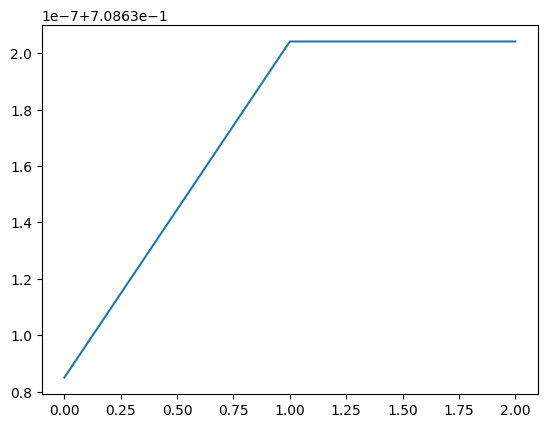

In [607]:
#it was much faster, but doesn't seem that it trains
plt.plot(losses_per_epoches_inf)

In [608]:
losses_per_epoches_inf

[0.7086301, 0.7086302, 0.7086302]

# Conclusions

It works faster but, doesn't seem to train, maybe we need to change hyperparameters. Or maybe we need to do like in article: sum representations from Long Term attention and regular one.